# benchmark.ipynb
## Benchmark Testing Using AUC - ROC Curves
### Purpose
The purpose of this notebook is to explore testing the ML algorithms written in this repo and their scores on a standard benchmark. This will help us identify what is the "best" algorithm to use for this specific kind of data analysis.

With reference to some resources, we can approach creating scripts to test various ML algorithms given that we feed them the same data set.

Reference:
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

"The **receiver-operating characteristic curve (ROC)** is a visual representation of model performance across all thresholds." We can draw this curve by calculating the **true positive rate (TPR)** and **false positive rate (FPR)** at every possible threshold, then graphing TPR over FPR.
+ A perfect model will have, at some threshold, a TPR of 1.0 and a FPR of 0.0.
+ A perfect model can be represented by either a point (0,1) if all other thresholds are ignored.

"The **area under the ROC curve (AUC)** represents the probability that the model, if given a randomly-chosen positive and negative example, will rank the positive higher than the negative."
+ A perfect model will have a 100% probability of ranking a randomly-chosen positive example higher than a randomly-chosen negative example.

AUC is a useful tool to compare the performance of two different models, as long as the **dataset is roughly balanced**.
+ Generally, **the model with the greatest area under the curve is the better one**.

Reference:
https://en.wikipedia.org/wiki/Receiver_operating_characteristic

The AUC - ROC curve is used solely for **binary classifier models** and **multi-class classification** models. The thresholds are the main contributors to the determination of the area under the curve.

With reference to statistics, we can think of the AUC - ROC curve as **a plot of the statistical power as a fucntion of the Type I error of the decision rule.
+ The ROC curve is just the sensitivity as a function of false positive rate.

The ROC curve, then, is just the cumulative distribution function (CDF) of the detection probability in the y-axis versus the CDF of the false positive probability on the x-axis.

With this in mind, we can now work to create scripts to create and show this curve for various fed models.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns

def evaluate_model_auc_roc(model, X_test, y_test, model_name="Model", plot=True):
    """
    Evaluate a binary classification model using AUC-ROC metrics
    
    Parameters:
    -----------
    model : trained model object
        Must have predict_proba method
    X_test : array-like
        Test features
    y_test : array-like
        True test labels
    model_name : str
        Name for the model (used in plots)
    plot : bool
        Whether to generate ROC curve plot
    
    Returns:
    --------
    dict : Dictionary containing evaluation metrics
    """
    
    # Get prediction probabilities
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    else:
        raise ValueError("Model must have predict_proba method for AUC-ROC calculation")
    
    # Get binary predictions
    y_pred = model.predict(X_test)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Alternative AUC calculation (should be the same)
    roc_auc_sklearn = roc_auc_score(y_test, y_proba)
    
    # Print results
    print(f"=== {model_name} AUC-ROC Evaluation ===")
    print(f"AUC-ROC Score: {roc_auc:.4f}")
    print(f"AUC-ROC (sklearn): {roc_auc_sklearn:.4f}")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    if plot:
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # ROC Curve
        ax1.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.4f})')
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
                label='Random Classifier')
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title(f'{model_name} - ROC Curve')
        ax1.legend(loc="lower right")
        ax1.grid(True, alpha=0.3)
        
        # Confusion Matrix Heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
        ax2.set_title(f'{model_name} - Confusion Matrix')
        ax2.set_ylabel('True Label')
        ax2.set_xlabel('Predicted Label')
        
        plt.tight_layout()
        plt.show()
    
    # Return metrics dictionary
    return {
        'auc_roc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

def cross_validate_auc_roc(model, X, y, cv_folds=5, model_name="Model"):
    """
    Perform cross-validation with AUC-ROC scoring
    
    Parameters:
    -----------
    model : sklearn model object
        Untrained model
    X : array-like
        Features
    y : array-like
        Labels
    cv_folds : int
        Number of cross-validation folds
    model_name : str
        Name for the model
    
    Returns:
    --------
    dict : Cross-validation results
    """
    
    print(f"=== {model_name} Cross-Validation AUC-ROC ===")
    
    # Stratified K-Fold to maintain class balance
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Cross-validation with AUC scoring
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
    
    print(f"Cross-Validation AUC-ROC Scores: {cv_scores}")
    print(f"Mean AUC-ROC: {cv_scores.mean():.4f}")
    print(f"Standard Deviation: {cv_scores.std():.4f}")
    print(f"95% Confidence Interval: {cv_scores.mean():.4f} ± {1.96 * cv_scores.std():.4f}")
    
    return {
        'cv_scores': cv_scores,
        'mean_auc': cv_scores.mean(),
        'std_auc': cv_scores.std()
    }

def load_and_evaluate_pickled_model(model_path, X_test, y_test, model_name="Pickled Model"):
    """
    Load a pickled model and evaluate it with AUC-ROC
    
    Parameters:
    -----------
    model_path : str
        Path to the pickled model file
    X_test : array-like
        Test features
    y_test : array-like
        Test labels
    model_name : str
        Name for the model
    
    Returns:
    --------
    dict : Evaluation results
    """
    
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        
        print(f"Successfully loaded model from {model_path}")
        
        # Evaluate the model
        results = evaluate_model_auc_roc(model, X_test, y_test, model_name)
        
        return results
        
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        return None

def benchmark_multiple_models(models_dict, X_test, y_test, plot_comparison=True):
    """
    Compare multiple models using AUC-ROC
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model_name: model_object pairs
    X_test : array-like
        Test features
    y_test : array-like
        Test labels
    plot_comparison : bool
        Whether to create comparison plot
    
    Returns:
    --------
    dict : Results for all models
    """
    
    results = {}
    
    if plot_comparison:
        plt.figure(figsize=(10, 8))
    
    for model_name, model in models_dict.items():
        print(f"\n{'='*50}")
        result = evaluate_model_auc_roc(model, X_test, y_test, model_name, plot=False)
        results[model_name] = result
        
        if plot_comparison:
            plt.plot(result['fpr'], result['tpr'], lw=2, 
                    label=f'{model_name} (AUC = {result["auc_roc"]:.4f})')
    
    if plot_comparison:
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # Summary table
    print(f"\n{'='*50}")
    print("SUMMARY - AUC-ROC Comparison")
    print(f"{'='*50}")
    for model_name, result in results.items():
        print(f"{model_name:20s}: AUC = {result['auc_roc']:.4f}")
    
    return results

# Example usage functions
def example_with_trained_model(trained_model, X_test, y_test):
    return evaluate_model_auc_roc(trained_model, X_test, y_test, "RandomForest")

def example_with_pickled_model(X_test, y_test):
    return load_and_evaluate_pickled_model('RandomForest_model.pkl', X_test, y_test, "RandomForest")

def example_cross_validation(X_train, y_train):
    from sklearn.ensemble import RandomForestClassifier
    
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    return cross_validate_auc_roc(model, X_train, y_train, cv_folds=5, model_name="RandomForest")

# Interpretation guide
def interpret_auc_roc_score(auc_score):
    """
    Provide interpretation of AUC-ROC score
    """
    print(f"\n=== AUC-ROC Score Interpretation ===")
    print(f"Your AUC-ROC Score: {auc_score:.4f}")
    
    if auc_score >= 0.9:
        interpretation = "Excellent"
    elif auc_score >= 0.8:
        interpretation = "Good"
    elif auc_score >= 0.7:
        interpretation = "Fair"
    elif auc_score >= 0.6:
        interpretation = "Poor"
    else:
        interpretation = "Very Poor (worse than random)"
    
    print(f"Interpretation: {interpretation}")
    print(f"""
    AUC-ROC Interpretation Guide:
    - 1.0: Perfect classifier
    - 0.9-1.0: Excellent
    - 0.8-0.9: Good  
    - 0.7-0.8: Fair
    - 0.6-0.7: Poor
    - 0.5-0.6: Very Poor
    - 0.5: Random classifier (no discriminative ability)
    - <0.5: Worse than random (but can be inverted)
    """)

=== TRAINING ML MODEL (MATCHED TO PREDICTION) ===
Target channels: ['Height', 'Amplitude', 'Phase', 'ZSensor']
Expected features: 4 channels * 4 stats + 6 pairs = 22
Found 58 good image files
Found 14 bad image files
Feature names (22): ['Amplitude_std', 'Amplitude_range', 'Amplitude_entropy', 'Amplitude_skew', 'Height_std', 'Height_range', 'Height_entropy', 'Height_skew', 'Phase_std', 'Phase_range', 'Phase_entropy', 'Phase_skew', 'ZSensor_std', 'ZSensor_range', 'ZSensor_entropy', 'ZSensor_skew', 'Amplitude_Height_residual', 'Amplitude_Phase_residual', 'Amplitude_ZSensor_residual', 'Height_Phase_residual', 'Height_ZSensor_residual', 'Phase_ZSensor_residual']
Successfully processed 58 good images
Successfully processed 14 bad images
Final training data: 72 samples, 22 features
Good images: 58, Bad images: 14
Training accuracy: 1.000
Test accuracy: 1.000
Cross-validation score: 0.876 (+/- 0.094)

Top 10 Most Important Features:
            feature  importance
0     Amplitude_std    0.132

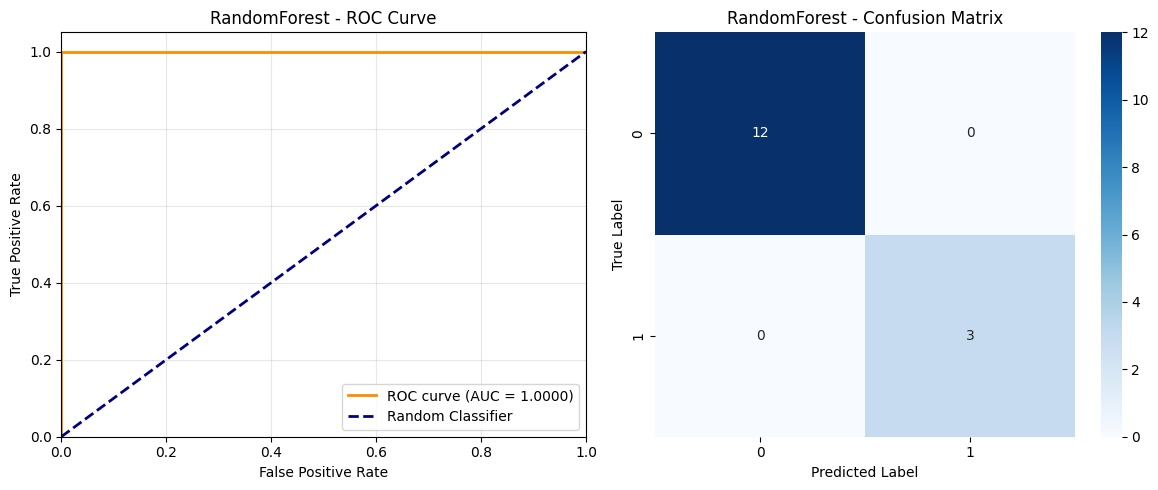

In [2]:
from utils import train_ml_model_matched
from aespm import ibw_read

bad_image_files = 'sorted_data/bad_images'
good_image_files = 'sorted_data/good_images'

# Train the model
results = train_ml_model_matched(bad_image_files, good_image_files, ibw_read)
auc_results = evaluate_model_auc_roc(
    results['model'], 
    results['X_test'], 
    results['y_test'], 
    "RandomForest"
)

In [ ]:
def train_multiple_ml_models(bad_image_files, good_image_files, ibw_read_func, models_to_train='all'):
    """
    Train multiple ML models using both good and bad image files directly
    
    Parameters:
    -----------
    bad_image_files : str or list
        Path to bad image files or list of file paths
    good_image_files : str or list  
        Path to good image files or list of file paths
    ibw_read_func : function
        Function to read IBW files
    models_to_train : str or list
        'all' to train all models, or list of model names to train
        Available: ['RandomForest', 'XGBoost', 'SVM', 'LogisticRegression', 'GradientBoosting', 'ExtraTrees']
    
    Returns:
    --------
    dict : Dictionary containing trained models and evaluation results
    """
    import numpy as np
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import cross_val_score, train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, confusion_matrix
    from xgboost import XGBClassifier
    import pickle
    import os
    
    print("=== TRAINING MULTIPLE ML MODELS ===")
    
    # Define available models
    available_models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=1),
        'SVM': SVC(probability=True, random_state=42, class_weight='balanced'),
        'LogisticRegression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    }
    
    # Determine which models to train
    if models_to_train == 'all':
        models_to_use = available_models
    else:
        models_to_use = {name: available_models[name] for name in models_to_train if name in available_models}
    
    print(f"Training models: {list(models_to_use.keys())}")
    
    # Use only the 4 channels that the prediction function uses
    target_channels = ['Height', 'Amplitude', 'Phase', 'ZSensor']
    
    print(f"Target channels: {target_channels}")
    
    # Calculate expected features: 4 stats per channel + pairwise residuals
    num_channels = len(target_channels)
    num_pairs = num_channels * (num_channels - 1) // 2
    expected_features = num_channels * 4 + num_pairs
    print(f"Expected features: {num_channels} channels * 4 stats + {num_pairs} pairs = {expected_features}")
    
    # Handle good image files
    if isinstance(good_image_files, str):
        if os.path.isdir(good_image_files):
            good_files = [os.path.join(good_image_files, f) for f in os.listdir(good_image_files) if f.endswith('.ibw')]
        else:
            good_files = [good_image_files]
    else:
        good_files = good_image_files
    
    # Handle bad image files
    if isinstance(bad_image_files, str):
        if os.path.isdir(bad_image_files):
            bad_files = [os.path.join(bad_image_files, f) for f in os.listdir(bad_image_files) if f.endswith('.ibw')]
        else:
            bad_files = [bad_image_files]
    else:
        bad_files = bad_image_files
    
    print(f"Found {len(good_files)} good image files")
    print(f"Found {len(bad_files)} bad image files")
    
    # Prepare feature matrix and labels
    X = []
    y = []
    
    # Feature names for consistency
    feature_names = []
    for ch_name in sorted(target_channels):
        feature_names.extend([f'{ch_name}_std', f'{ch_name}_range', f'{ch_name}_entropy', f'{ch_name}_skew'])
    
    # Add pairwise residual names
    sorted_channels = sorted(target_channels)
    for i in range(len(sorted_channels)):
        for j in range(i + 1, len(sorted_channels)):
            feature_names.append(f'{sorted_channels[i]}_{sorted_channels[j]}_residual')
    
    print(f"Feature names ({len(feature_names)}): {feature_names}")
    
    def extract_features_from_ibw(ibw_file, label):
        """Extract features from an IBW file"""
        try:
            ibw = ibw_read_func(ibw_file)
            
            # Create data dictionary like check_failure_flags expects
            data_dict = {}
            
            # Extract channel data based on ibw structure
            if hasattr(ibw.data, 'shape'):
                if len(ibw.data.shape) == 3:
                    # Assume channels are in the 3rd dimension
                    num_data_channels = ibw.data.shape[2]
                    channel_mapping = ['Height', 'Amplitude', 'Phase', 'ZSensor'][:num_data_channels]
                    
                    for i, ch_name in enumerate(channel_mapping):
                        if ch_name in target_channels:
                            data_dict[ch_name] = ibw.data[:, :, i]
                            
                elif len(ibw.data.shape) == 2:
                    # Single channel or needs reshaping
                    if len(target_channels) == 1:
                        data_dict[target_channels[0]] = ibw.data
                    else:
                        # Try to split into channels
                        total_size = ibw.data.size
                        if total_size % len(target_channels) == 0:
                            pixels_per_channel = total_size // len(target_channels)
                            flattened = ibw.data.flatten()
                            for i, ch_name in enumerate(sorted(target_channels)):
                                start_idx = i * pixels_per_channel
                                end_idx = (i + 1) * pixels_per_channel
                                data_dict[ch_name] = flattened[start_idx:end_idx]
            
            # Extract features like check_failure_flags does
            features = []
            
            for ch_name in sorted(target_channels):
                if ch_name in data_dict:
                    channel_data = data_dict[ch_name].flatten()
                    
                    mean = np.mean(channel_data)
                    std = np.std(channel_data)
                    median = np.median(channel_data)
                    range_val = np.ptp(channel_data)
                    
                    # Compute entropy
                    hist, _ = np.histogram(channel_data, bins=256, density=True)
                    hist = hist[hist > 0]
                    entropy = -np.sum(hist * np.log(hist + 1e-12)) if len(hist) > 0 else 0
                    
                    skew = abs(mean - median)
                    features.extend([std, range_val, entropy, skew])
                else:
                    # Channel not available, use zeros
                    features.extend([0, 0, 0, 0])
            
            # Add pairwise residuals
            for i in range(len(sorted_channels)):
                for j in range(i + 1, len(sorted_channels)):
                    ch1_name, ch2_name = sorted_channels[i], sorted_channels[j]
                    if ch1_name in data_dict and ch2_name in data_dict:
                        ch1_data = data_dict[ch1_name].flatten()
                        ch2_data = data_dict[ch2_name].flatten()
                        
                        # Ensure same length
                        min_len = min(len(ch1_data), len(ch2_data))
                        residual = np.mean(np.abs(ch1_data[:min_len] - ch2_data[:min_len]))
                        features.append(residual)
                    else:
                        features.append(0)
            
            if len(features) == expected_features:
                X.append(features)
                y.append(label)
                return True
            else:
                print(f"Feature count mismatch for {os.path.basename(ibw_file)}: got {len(features)}, expected {expected_features}")
                return False
                
        except Exception as e:
            print(f"Failed to process {os.path.basename(ibw_file)}: {e}")
            return False
    
    # Process good images (label = 0)
    good_processed = 0
    for good_file in good_files:
        if extract_features_from_ibw(good_file, 0):  # 0 = good
            good_processed += 1
    
    print(f"Successfully processed {good_processed} good images")
    
    # Process bad images (label = 1)
    bad_processed = 0
    for bad_file in bad_files:
        if extract_features_from_ibw(bad_file, 1):  # 1 = bad
            bad_processed += 1
    
    print(f"Successfully processed {bad_processed} bad images")

    X = np.array(X)
    y = np.array(y)
    
    print(f"Final training data: {len(X)} samples, {X.shape[1]} features")
    print(f"Good images: {sum(y == 0)}, Bad images: {sum(y == 1)}")
    
    if len(X) == 0:
        print("No training data available!")
        return None
        
    if len(np.unique(y)) < 2:
        print("ERROR: Need both good and bad samples for training!")
        return None
    
    # Split data once for all models
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Scale data once
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train all models
    trained_models = {}
    results_summary = []
    
    print(f"\n{'='*60}")
    print("TRAINING AND EVALUATING MODELS")
    print(f"{'='*60}")
    
    for model_name, model in models_to_use.items():
        print(f"\n--- Training {model_name} ---")
        
        # Train the model
        model.fit(X_train_scaled, y_train)
        
        # Evaluate
        train_score = model.score(X_train_scaled, y_train)
        test_score = model.score(X_test_scaled, y_test)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
        
        print(f"Training accuracy: {train_score:.3f}")
        print(f"Test accuracy: {test_score:.3f}")
        print(f"Cross-validation AUC-ROC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        
        # Store results
        results_summary.append({
            'Model': model_name,
            'Train_Accuracy': train_score,
            'Test_Accuracy': test_score,
            'CV_AUC_Mean': cv_scores.mean(),
            'CV_AUC_Std': cv_scores.std()
        })
        
        # Create combined model with scaler
        combined_model = ScaledModel(model, scaler)
        trained_models[model_name] = combined_model
        
        # Save individual model
        filename = f'{model_name}_model.pkl'
        # Ensure the "models" directory exists
        os.makedirs("models", exist_ok=True)
        model_path = os.path.join("models", filename)
        with open(model_path, 'wb') as f:
            pickle.dump(combined_model, f)
        print(f"Model saved as '{filename}'")
    
    # Results summary
    results_df = pd.DataFrame(results_summary)
    results_df = results_df.sort_values('CV_AUC_Mean', ascending=False)
    
    print(f"\n{'='*60}")
    print("MODELS PERFORMANCE SUMMARY (Ranked by CV AUC-ROC)")
    print(f"{'='*60}")
    print(results_df.to_string(index=False, float_format='%.3f'))
    
    # Feature importance for tree-based models
    print(f"\n{'='*60}")
    print("FEATURE IMPORTANCE (Top 10)")
    print(f"{'='*60}")
    
    for model_name, combined_model in trained_models.items():
        if hasattr(combined_model.model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': combined_model.model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(f"\n{model_name} - Top 10 Features:")
            print(importance_df.head(10).to_string(index=False, float_format='%.4f'))
    
    return {
        'models': trained_models,
        'results_summary': results_df,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'feature_names': feature_names
    }

# Wrapper class (same as before)
class ScaledModel:
    """Wrapper class to combine model and scaler"""
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler
        
    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled)
        
    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict_proba(X_scaled)
        
    @property
    def feature_importances_(self):
        if hasattr(self.model, 'feature_importances_'):
            return self.model.feature_importances_
        else:
            return None

# Helper functions
def train_all_models(bad_image_files, good_image_files, ibw_read_func):
    """Train all available models"""
    return train_multiple_ml_models(bad_image_files, good_image_files, ibw_read_func, models_to_train='all')

def train_specific_models(bad_image_files, good_image_files, ibw_read_func, model_list):
    """Train specific models"""
    return train_multiple_ml_models(bad_image_files, good_image_files, ibw_read_func, models_to_train=model_list)

=== TRAINING MULTIPLE ML MODELS ===
Training models: ['RandomForest', 'XGBoost', 'SVM', 'LogisticRegression', 'GradientBoosting', 'ExtraTrees']
Target channels: ['Height', 'Amplitude', 'Phase', 'ZSensor']
Expected features: 4 channels * 4 stats + 6 pairs = 22
Found 58 good image files
Found 14 bad image files
Feature names (22): ['Amplitude_std', 'Amplitude_range', 'Amplitude_entropy', 'Amplitude_skew', 'Height_std', 'Height_range', 'Height_entropy', 'Height_skew', 'Phase_std', 'Phase_range', 'Phase_entropy', 'Phase_skew', 'ZSensor_std', 'ZSensor_range', 'ZSensor_entropy', 'ZSensor_skew', 'Amplitude_Height_residual', 'Amplitude_Phase_residual', 'Amplitude_ZSensor_residual', 'Height_Phase_residual', 'Height_ZSensor_residual', 'Phase_ZSensor_residual']
Successfully processed 58 good images
Successfully processed 14 bad images
Final training data: 72 samples, 22 features
Good images: 58, Bad images: 14

TRAINING AND EVALUATING MODELS

--- Training RandomForest ---
Training accuracy: 1.000

/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow 

Training accuracy: 1.000
Test accuracy: 1.000
Cross-validation AUC-ROC: 0.911 (+/- 0.151)
Model saved as 'ExtraTrees_model.pkl'

MODELS PERFORMANCE SUMMARY (Ranked by CV AUC-ROC)
             Model  Train_Accuracy  Test_Accuracy  CV_AUC_Mean  CV_AUC_Std
      RandomForest           1.000          1.000        0.926       0.059
           XGBoost           1.000          0.933        0.919       0.043
        ExtraTrees           1.000          1.000        0.911       0.075
LogisticRegression           0.684          0.733        0.831       0.115
  GradientBoosting           1.000          1.000        0.830       0.183
               SVM           0.579          0.667        0.821       0.123

FEATURE IMPORTANCE (Top 10)

RandomForest - Top 10 Features:
        feature  importance
  Amplitude_std      0.1330
    Height_skew      0.1279
     Phase_skew      0.0945
      Phase_std      0.0852
     Height_std      0.0845
 Amplitude_skew      0.0811
   ZSensor_skew      0.0656
Amplitude_

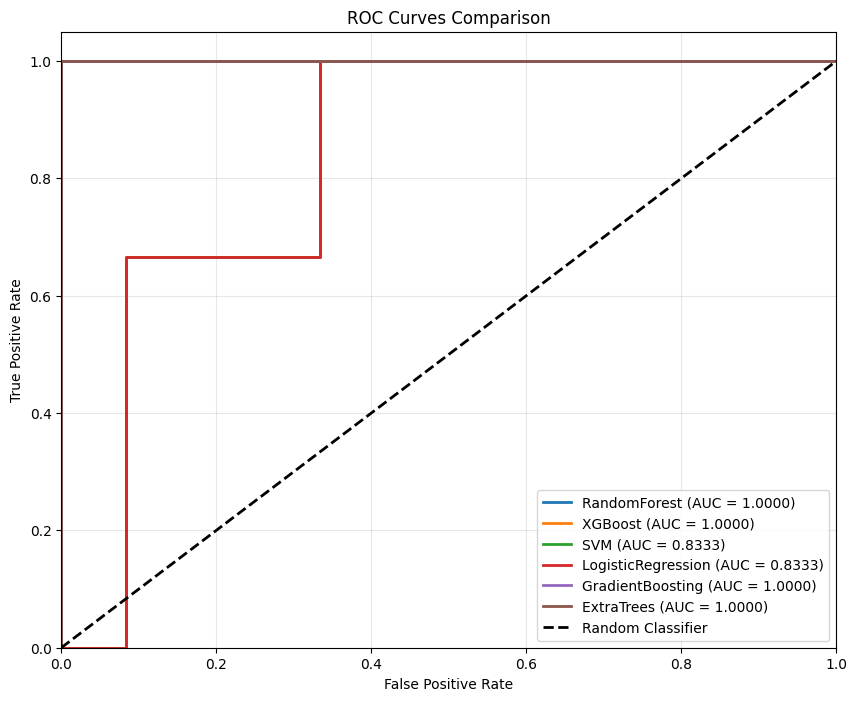


SUMMARY - AUC-ROC Comparison
RandomForest        : AUC = 1.0000
XGBoost             : AUC = 1.0000
SVM                 : AUC = 0.8333
LogisticRegression  : AUC = 0.8333
GradientBoosting    : AUC = 1.0000
ExtraTrees          : AUC = 1.0000


In [16]:
results = train_all_models(bad_image_files, good_image_files, ibw_read)

auc_results = benchmark_multiple_models(
    results['models'],     # Dictionary of all trained models
    results['X_test'],     # Test features
    results['y_test'],     # Test labels
    plot_comparison=True   # Creates comparison ROC plot
)

## Testing the Efficacy of the Benchmark
We will use the same synthesis tool created to make fake datasets and train several models (to simulate larger data sets).

In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

from utils import create_batch_synthetic_images, create_synthetic

class ScaledModel:
    """Wrapper class to combine model and scaler"""
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler
        
    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled)
        
    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict_proba(X_scaled)
        
    @property
    def feature_importances_(self):
        if hasattr(self.model, 'feature_importances_'):
            return self.model.feature_importances_
        else:
            return None

def train_multiple_ml_models_from_synthetic_sets(good_set, bad_set, models_to_train='all'):
    """
    Train multiple ML models using synthetic good and bad image sets with only the 4 channels
    that check_failure_flags uses.
    
    Parameters:
    -----------
    good_set : list
        List of synthetic good image dictionaries
    bad_set : list
        List of synthetic bad image dictionaries
    models_to_train : str or list
        'all' to train all models, or list of model names to train
        Available: ['RandomForest', 'XGBoost', 'SVM', 'LogisticRegression', 'GradientBoosting', 'ExtraTrees']
    
    Returns:
    --------
    dict : Dictionary containing trained models and evaluation results
    """
    
    import os
    
    print("=== TRAINING MULTIPLE ML MODELS FROM SYNTHETIC SETS ===")
    
    # Define available models
    available_models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss'),
        'SVM': SVC(probability=True, random_state=42, class_weight='balanced'),
        'LogisticRegression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    }
    
    # Determine which models to train
    if models_to_train == 'all':
        models_to_use = available_models
    else:
        models_to_use = {name: available_models[name] for name in models_to_train if name in available_models}
    
    print(f"Training models: {list(models_to_use.keys())}")

    target_channels = ['Height', 'Amplitude', 'Phase', 'ZSensor']
    available_channels = target_channels.copy()
    print(f"Using channels: {available_channels}")

    num_channels = len(available_channels)
    num_pairs = num_channels * (num_channels - 1) // 2
    expected_features = num_channels * 4 + num_pairs
    print(f"Expected features: {num_channels} channels * 4 stats + {num_pairs} pairs = {expected_features}")

    # Prepare features and labels
    X = []
    y = []

    # Feature names for consistency
    feature_names = []
    for ch in sorted(available_channels):
        feature_names.extend([f'{ch}_std', f'{ch}_range', f'{ch}_entropy', f'{ch}_skew'])
    
    # Add pairwise residual names
    sorted_channels = sorted(available_channels)
    for i in range(len(sorted_channels)):
        for j in range(i + 1, len(sorted_channels)):
            feature_names.append(f'{sorted_channels[i]}_{sorted_channels[j]}_residual')
    
    print(f"Feature names ({len(feature_names)}): {feature_names}")

    def extract_features(image_dict):
        """Extract features from synthetic image dictionary"""
        features = []
        
        # Extract statistical features for each channel
        for ch in sorted(available_channels):
            data = image_dict[ch].flatten()
            mean = np.mean(data)
            std = np.std(data)
            median = np.median(data)
            range_val = np.ptp(data)
            
            # Compute entropy
            hist, _ = np.histogram(data, bins=256, density=True)
            hist = hist[hist > 0]
            entropy = -np.sum(hist * np.log(hist + 1e-12)) if len(hist) > 0 else 0
            
            skew = abs(mean - median)
            features.extend([std, range_val, entropy, skew])
        
        # Add pairwise residuals
        for i in range(len(sorted_channels)):
            for j in range(i + 1, len(sorted_channels)):
                ch1 = sorted_channels[i]
                ch2 = sorted_channels[j]
                data1 = image_dict[ch1].flatten()
                data2 = image_dict[ch2].flatten()
                
                # Ensure same length
                min_len = min(len(data1), len(data2))
                residual = np.mean(np.abs(data1[:min_len] - data2[:min_len]))
                features.append(residual)
        
        return features

    # Process good images (label = 0)
    good_processed = 0
    for entry in good_set:
        try:
            feats = extract_features(entry['image_dict'])
            if len(feats) == expected_features:
                X.append(feats)
                y.append(0)  # 0 = good
                good_processed += 1
        except Exception as e:
            print(f"Failed to process good synthetic image: {e}")
    
    print(f"Successfully processed {good_processed} good synthetic images")

    # Process bad images (label = 1)
    bad_processed = 0
    for entry in bad_set:
        try:
            feats = extract_features(entry['image_dict'])
            if len(feats) == expected_features:
                X.append(feats)
                y.append(1)  # 1 = bad
                bad_processed += 1
        except Exception as e:
            print(f"Failed to process bad synthetic image: {e}")
    
    print(f"Successfully processed {bad_processed} bad synthetic images")

    X = np.array(X)
    y = np.array(y)

    print(f"Final training data: {len(X)} samples, {X.shape[1]} features")
    print(f"Good images: {sum(y == 0)}, Bad images: {sum(y == 1)}")

    if len(X) == 0:
        print("No training data available!")
        return None
        
    if len(np.unique(y)) < 2:
        print("ERROR: Need both good and bad samples for training!")
        return None

    # Split data once for all models
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Scale data once
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Adjust XGBoost scale_pos_weight based on actual data
    neg_samples, pos_samples = np.bincount(y_train)
    scale_pos_weight = neg_samples / pos_samples if pos_samples > 0 else 1
    if 'XGBoost' in models_to_use:
        models_to_use['XGBoost'].set_params(scale_pos_weight=scale_pos_weight)
    
    # Train all models
    trained_models = {}
    results_summary = []
    
    print(f"\n{'='*60}")
    print("TRAINING AND EVALUATING MODELS")
    print(f"{'='*60}")
    
    for model_name, model in models_to_use.items():
        print(f"\n--- Training {model_name} ---")
        
        # Train the model
        model.fit(X_train_scaled, y_train)
        
        # Evaluate
        train_score = model.score(X_train_scaled, y_train)
        test_score = model.score(X_test_scaled, y_test)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
        
        print(f"Training accuracy: {train_score:.3f}")
        print(f"Test accuracy: {test_score:.3f}")
        print(f"Cross-validation AUC-ROC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        
        # Store results
        results_summary.append({
            'Model': model_name,
            'Train_Accuracy': train_score,
            'Test_Accuracy': test_score,
            'CV_AUC_Mean': cv_scores.mean(),
            'CV_AUC_Std': cv_scores.std()
        })
        
        # Create combined model with scaler
        combined_model = ScaledModel(model, scaler)
        trained_models[model_name] = combined_model
        
        # Save individual model
        filename = f'synthetic_{model_name}_model.pkl'
        # Ensure the "models" directory exists
        os.makedirs("models", exist_ok=True)
        model_path = os.path.join("models", filename)
        with open(model_path, 'wb') as f:
            pickle.dump(combined_model, f)
        print(f"Model saved as '{filename}'")
    
    # Results summary
    results_df = pd.DataFrame(results_summary)
    results_df = results_df.sort_values('CV_AUC_Mean', ascending=False)
    
    print(f"\n{'='*60}")
    print("MODELS PERFORMANCE SUMMARY (Ranked by CV AUC-ROC)")
    print(f"{'='*60}")
    print(results_df.to_string(index=False, float_format='%.3f'))
    
    # Feature importance for tree-based models
    print(f"\n{'='*60}")
    print("FEATURE IMPORTANCE (Top 10)")
    print(f"{'='*60}")
    
    for model_name, combined_model in trained_models.items():
        if hasattr(combined_model.model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': combined_model.model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(f"\n{model_name} - Top 10 Features:")
            print(importance_df.head(10).to_string(index=False, float_format='%.4f'))
    
    return {
        'models': trained_models,
        'results_summary': results_df,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'feature_names': feature_names
    }

# Convenience functions (similar to the real data version)
def train_all_synthetic_models(good_set, bad_set):
    """Train all available models using synthetic data"""
    return train_multiple_ml_models_from_synthetic_sets(good_set, bad_set, models_to_train='all')

def train_specific_synthetic_models(good_set, bad_set, model_list):
    """Train specific models using synthetic data"""
    return train_multiple_ml_models_from_synthetic_sets(good_set, bad_set, models_to_train=model_list)

def compare_tree_synthetic_models(good_set, bad_set):
    """Train only tree-based models for comparison using synthetic data"""
    tree_models = ['RandomForest', 'XGBoost', 'GradientBoosting', 'ExtraTrees']
    return train_multiple_ml_models_from_synthetic_sets(good_set, bad_set, models_to_train=tree_models)

def train_and_generate_multiple_models(num_good_images=50, num_bad_images=50, models_to_train='all'):
    """
    Generate synthetic data and train multiple models
    
    Parameters:
    -----------
    num_good_images : int
        Number of good synthetic images to generate
    num_bad_images : int
        Number of bad synthetic images to generate
    models_to_train : str or list
        Models to train ('all' or list of model names)
    
    Returns:
    --------
    dict : Dictionary containing trained models and evaluation results
    """
    print(f"Generating {num_good_images} good and {num_bad_images} bad synthetic images...")
    
    bad_set = create_batch_synthetic_images(num_images=num_bad_images, set_type='bad')
    good_set = create_batch_synthetic_images(num_images=num_good_images, set_type='good')
    
    results = train_multiple_ml_models_from_synthetic_sets(good_set, bad_set, models_to_train)
    return results

Generating 50 good and 50 bad synthetic images...
=== TRAINING MULTIPLE ML MODELS FROM SYNTHETIC SETS ===
Training models: ['RandomForest', 'XGBoost', 'SVM', 'LogisticRegression', 'GradientBoosting', 'ExtraTrees']
Using channels: ['Height', 'Amplitude', 'Phase', 'ZSensor']
Expected features: 4 channels * 4 stats + 6 pairs = 22
Feature names (22): ['Amplitude_std', 'Amplitude_range', 'Amplitude_entropy', 'Amplitude_skew', 'Height_std', 'Height_range', 'Height_entropy', 'Height_skew', 'Phase_std', 'Phase_range', 'Phase_entropy', 'Phase_skew', 'ZSensor_std', 'ZSensor_range', 'ZSensor_entropy', 'ZSensor_skew', 'Amplitude_Height_residual', 'Amplitude_Phase_residual', 'Amplitude_ZSensor_residual', 'Height_Phase_residual', 'Height_ZSensor_residual', 'Phase_ZSensor_residual']
Successfully processed 50 good synthetic images
Successfully processed 50 bad synthetic images
Final training data: 100 samples, 22 features
Good images: 50, Bad images: 50

TRAINING AND EVALUATING MODELS

--- Training Ra

/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:57:54] WARNING: /Users/runner/work/xgboost/

Training accuracy: 1.000
Test accuracy: 0.500
Cross-validation AUC-ROC: 0.669 (+/- 0.369)
Model saved as 'synthetic_XGBoost_model.pkl'

--- Training SVM ---
Training accuracy: 0.900
Test accuracy: 0.400
Cross-validation AUC-ROC: 0.584 (+/- 0.179)
Model saved as 'synthetic_SVM_model.pkl'

--- Training LogisticRegression ---
Training accuracy: 0.800
Test accuracy: 0.400
Cross-validation AUC-ROC: 0.606 (+/- 0.072)
Model saved as 'synthetic_LogisticRegression_model.pkl'

--- Training GradientBoosting ---


/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/colin/Documents/GitHub/ofdspm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow 

Training accuracy: 1.000
Test accuracy: 0.350
Cross-validation AUC-ROC: 0.669 (+/- 0.297)
Model saved as 'synthetic_GradientBoosting_model.pkl'

--- Training ExtraTrees ---
Training accuracy: 1.000
Test accuracy: 0.450
Cross-validation AUC-ROC: 0.588 (+/- 0.190)
Model saved as 'synthetic_ExtraTrees_model.pkl'

MODELS PERFORMANCE SUMMARY (Ranked by CV AUC-ROC)
             Model  Train_Accuracy  Test_Accuracy  CV_AUC_Mean  CV_AUC_Std
           XGBoost           1.000          0.500        0.669       0.185
  GradientBoosting           1.000          0.350        0.669       0.149
      RandomForest           1.000          0.550        0.637       0.110
LogisticRegression           0.800          0.400        0.606       0.036
        ExtraTrees           1.000          0.450        0.588       0.095
               SVM           0.900          0.400        0.584       0.089

FEATURE IMPORTANCE (Top 10)

RandomForest - Top 10 Features:
                   feature  importance
            

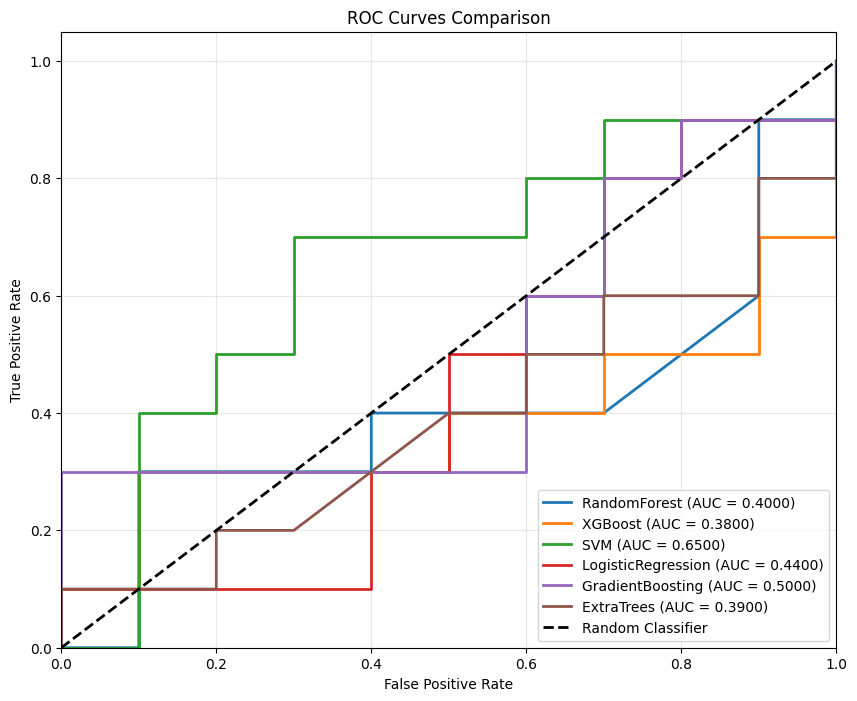


SUMMARY - AUC-ROC Comparison
RandomForest        : AUC = 0.4000
XGBoost             : AUC = 0.3800
SVM                 : AUC = 0.6500
LogisticRegression  : AUC = 0.4400
GradientBoosting    : AUC = 0.5000
ExtraTrees          : AUC = 0.3900
Best performing model: XGBoost


In [11]:
# Train all models
results = train_and_generate_multiple_models(num_good_images=50, num_bad_images=50, models_to_train='all')

# # Train specific models
# results = train_and_generate_multiple_models(num_good_images=50, num_bad_images=50, models_to_train=['RandomForest', 'XGBoost'])

# # Train only tree-based models
# results = train_and_generate_multiple_models(num_good_images=75, num_bad_images=75, models_to_train=['RandomForest', 'XGBoost', 'GradientBoosting', 'ExtraTrees'])

auc_results = benchmark_multiple_models(
    results['models'],     # Dictionary of all trained models
    results['X_test'],     # Test features
    results['y_test'],     # Test labels
    plot_comparison=True   # Creates comparison ROC plot
)
    
